# Create global sky from MSA cutouts

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import astropy.io.fits as pyfits

from tqdm import tqdm
import scipy.ndimage as nd

import eazy

import grizli
from grizli import utils

import msaexp
import msaexp.slit_combine
import msaexp.utils

print('grizli: ', grizli.__version__)
print('msaexp: ', msaexp.__version__)

grizli:  1.11.7.dev5+ga1d229d.d20240522
msaexp:  0.9.dev4+g8ed8647.d20240510


# Exposure prefix

The global background is determined seperately for each observation "visit", indicated by the exposure filename prefix.

In [ ]:
# rubies-egs61
visit = 'jw04233006001'

# Find files

In a directory with a set of ``*phot.*fits`` 2D cutouts, try to find all of the background slitlets.

1. Start with ``{visit}*phot*.b*fits`` shutters that should truly be background
2. If not enough found, try ``{visit}*phot*_m*fits`` that are usually user-specified background shutters (but sometimes these are sources)
3. If still not enough found, use all files ``{visit}*phot*_*fits``



In [ ]:
# Find files

files = glob.glob(f'{visit}*phot.*.b*.fits')

if len(files) < 5:
    print('Try to add "m" files')
    files += glob.glob(f'{visit}*phot.*_m*.fits')
    print(len(files))
else:
    print(f"found {len(files)} \".b\" files")
    
if len(files) < 5:
    print("add all files")
    files += glob.glob(f'{visit}*phot.*_*.fits')
    
files.sort()
files = np.array(files)
# files = files[:900]
keys = ['.'.join(f.split('_')[:2]) + '.' + f.split('_')[3] + '.' + f.split('.')[1] for f in files]

files.sort()
len(files)

In [ ]:
# files.sort()
un = utils.Unique(keys)
print(un.N)

# Initialize `msaexp.slit_combine.SlitGroup` objects

In [ ]:
bobj = {}

num_shutters = 3
# num_shutters = 2
# num_shutters = 1

num_shutters = 0 # Any shutter combination for sky

do_grating = ['PRISM']

total_count = 0

for ik, k in enumerate(un.values):
    # if k not in ['nrs2.110']:
    #     continue

    print(f'{ik+1} / {un.N} {k}\n\n')
    
    # if un[k].sum() == 3:
    if un[k].sum() >= 0:
        
        with pyfits.open(files[un[k]][0]) as im:
            if (len(im[1].header['SHUTSTA']) != num_shutters) & (num_shutters > 0):
                print('skip', k, im[1].header['SHUTSTA'])
                continue

            if im[1].header['NAXIS1'] < 200:
                print('skip', k, im[1].header['NAXIS1'])
                continue

            if im[0].header['GRATING'] not in do_grating:
                print('skip', k, im[0].header['GRATING'])
                continue                
        
        _obj = msaexp.slit_combine.SlitGroup(files[un[k]], 'test', position_key='y_index',
                                            undo_pathloss=True,
                                            trace_with_ypos=False, 
                                            trace_from_yoffset=True,
                                            stuck_min_sn=-100,
                                             undo_barshadow=False,
                                             fix_prism_norm=True,
                                             pad_border=2,
                                             flag_profile_kwargs=None,
                                             hot_cold_kwargs=None,
                                             # bad_shutter_names=[],
                                             sky_arrays=None, #(fixed_slit_wave, fixed_slit_sky),
                                            nod_offset=None)

        # only 3-shutters
        if (len(_obj.info['shutter_state'][0]) != num_shutters) & (num_shutters > 0):
            continue

        if len(_obj.meta['bad_shutter_names']) > 0:
            continue

        # tfit = obj.get_trace_sn()
        # sn_value = np.nanpercentile(tfit["sn"], 86)
        # if sn_value > 3:
        #     print('skip', k, 'S/N', sn_value)
        #     continue
            
        # Only mostly complete spectra
        if _obj.sh[1] > 200:
            bobj[k] = _obj
            obj = _obj
            total_count += _obj.N
            # break

        if total_count > 500:
            break
            

# Compute the average sky across all shutters

In [ ]:
fixed_slit_wave = np.arange(5000, 5.5e4) / 1.e4
fixed_slit_sky = fixed_slit_wave**0

In [ ]:
from tqdm import tqdm
import scipy.ndimage as nd
import msaexp.utils as msautils

fig, ax = plt.subplots(1,1,figsize=(8, 5))

ydata = []
fdata = []
wdata = []
edata = []
rndata = []

for k in tqdm(bobj):
    obj = bobj[k]
    if len(obj.meta["bad_shutter_names"]) > 0:
        continue

    # Just compute average from NRS2
    if 'xnrs1' in k:
        continue
    
    sn = obj.sci*1
    sne = np.sqrt(obj.var_total)
    rn = np.sqrt(obj.var_rnoise)

    shutter_y = obj.fixed_yshutter
    
    y_shutter_index = (obj.yslit + 1)/5

    oky = np.isfinite(shutter_y + obj.bar + sn) & (sn > -0.1) & (sn < 1)

    shutter_mid = obj.bar > 0.95
    shutter_mid &= np.abs(y_shutter_index - np.round(y_shutter_index)) < 0.2
    shutter_mid &= np.isfinite(obj.wave + obj.sci)

    if (obj.source_ypixel_position != 0.) & (len(obj.info['shutter_state'][0]) > 1):
        shutter_mid &= np.abs(obj.yslit - obj.source_ypixel_position) > 5
        
    oky &= shutter_mid
    # print(oky.sum())
    
    wsub = oky & (np.abs(obj.wave - 1.7) < 10.3) & np.isfinite(sn)
    if wsub.sum() < 256:
        continue
        
    # ax.scatter(obj.wave[oky], sn[oky], alpha=0.1)
    
    ydata.append(shutter_y[oky])
    wdata.append(obj.wave[oky])
    fdata.append(sn[oky])
    edata.append(sne[oky])
    rndata.append(rn[oky])

if 0:
    # Scale
    N = len(wdata)
    rescale = np.zeros(N)
    
    for i in range(N):
        wsub = np.abs(wdata[i] - 1.7) < 0.3
        rescale[i] = np.nanmedian(fdata[i][wsub])
    
    rescale /= np.median(rescale)
    for i in range(N):
        fdata[i] /= rescale[i]
        edata[i] /= rescale[i]
        rndata[i] /= rescale[i]

    keep = np.where((rescale > 0.9) & (rescale < 1.1))[0]
else:
    keep = np.arange(len(wdata), dtype=int)
    
ydata =  np.hstack([ydata[i] for i in keep])
wdata =  np.hstack([wdata[i] for i in keep])
fdata =  np.hstack([fdata[i] for i in keep])
edata =  np.hstack([edata[i] for i in keep])
rndata = np.hstack([rndata[i] for i in keep])

so = np.argsort(wdata)

sky_wave, sky_flux = wdata[so], nd.median_filter(fdata[so], 60)
okx = np.abs(fdata[so] - sky_flux) < 2*edata[so]
sky_wave, sky_flux = wdata[so][okx], nd.gaussian_filter(fdata[so][okx], 60)

# Fit cubic splines to sky
sky_df = 81

# sky_df = 31

if 0:
    wrange = (0.6, 5.4)
    bspl = utils.bspline_templates(wdata, df=sky_df, minmax=wrange, get_matrix=True)
    splx = np.linspace(*wrange, 1024)
    wgrid = splx
    bsplm = utils.bspline_templates(splx, df=sky_df, minmax=wrange, get_matrix=True)
else:
    
    wgrid = msautils.get_standard_wavelength_grid('PRISM', sample=3.0)
    ngrid = len(wgrid)
    splx = np.arange(ngrid)/ngrid
    xdata = np.interp(wdata, wgrid, splx)
    wrange = (0,1)
    
    bspl = utils.bspline_templates(xdata, df=sky_df, minmax=wrange, get_matrix=True)
    bsplm = utils.bspline_templates(splx, df=sky_df, minmax=wrange, get_matrix=True)

    if 1:
        full_interp = np.interp(wdata, fixed_slit_wave, fixed_slit_sky, left=np.nan, right=np.nan)
        okx &= np.isfinite(full_interp[so])
        bspl = (bspl.T * full_interp).T
        bsplm = (bsplm.T * np.interp(wgrid, fixed_slit_wave, fixed_slit_sky)).T

_csky = np.linalg.lstsq((bspl.T/rndata).T[so[okx],:], (fdata/rndata)[so][okx], rcond=None)
sky0 = bspl.dot(_csky[0])
print('iter0', okx.sum())
okx = np.abs(fdata[so] - sky0[so]) < 3*edata[so]
print('iter1', okx.sum())
_csky = np.linalg.lstsq((bspl.T/rndata).T[so[okx],:], (fdata/rndata)[so][okx], rcond=None)
sky1 = bspl.dot(_csky[0])

ax.scatter(wdata[so], (fdata[so] - sky1[so]) / edata[so], color='k', alpha=0.01)

sply = bsplm.dot(_csky[0])

ax.plot(wgrid, sply*0, color='magenta')
ax.set_xlabel('wavelength')
# ax.set_ylabel('sky flux density, uJy')

sply[(wgrid < wdata.min()) | (wgrid > wdata.max())] = np.nan

average_sky_wave = wgrid
average_sky_flux = sply*1.

ax.set_ylim(-5, 5)
ax.grid()

# plt.ylim(-0.1, 0.6)

## Fit the background components

1. Sun spectrum for zodi, modified with spline templates
2. HeI-1083 emission line for solar system
3. Flexible splines for diffuse galactic


In [ ]:
poly = utils.polynomial_templates(xdata, ref_wave=0.5, order=3)
spl_poly = np.array([poly[k].flux for k in poly])
spl_poly.shape

# utils.cheb_templates?

In [ ]:
from msaexp.resample_numba import resample_template_numba as resample_func
import msaexp
from grizli import utils

sun = utils.read_catalog('https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/sun_mod_001.fits')
sun['wave'] = sun['WAVELENGTH'] / 1.e4
sun = sun[(sun['wave'] > 0.5) & (sun['wave'] < 5.5)]

sun['fnu'] = sun['FLUX'] / 3.e18 * sun['WAVELENGTH']**2 * 1.e8

dl = 100./3.e5*1.083
sun['he_flam'] = 1./np.sqrt(2*np.pi*dl**2)*np.exp(-(sun['wave']-1.083)**2/2/dl**2)
sun['line He1083'] = sun['he_flam'] / (sun['wave']/1.083)**2

pah = utils.pah33(sun['wave']*1.e4)
for k in pah:
    sun[k] = pah[k].flux_fnu

df_sun = 5
df = 81

spl_func, spl_kws, df_key, spl_off = utils.bspline_templates, dict(minmax=(0,1), get_matrix=True), 'df', 0.
# spl_func, spl_kws, df_key, spl_off = utils.cheb_templates, dict(minmax=(0, 1), get_matrix=True), 'order', 0. #-0.5

spl_cont = spl_func(xdata + spl_off, **spl_kws, **{df_key: df})
spl_sun = spl_func(xdata + spl_off, **spl_kws, **{df_key: df_sun})

########
scale_disp = 1.3

g = 'PRISM'

_data_path = os.path.dirname(msaexp.__file__)
disp = utils.read_catalog(f'{_data_path}/data/jwst_nirspec_{g}_disp.fits'.lower())

scale_he = 1.

spec_R_fwhm = np.interp(wdata, disp['WAVELENGTH'],
                        disp['R'],
                        left=disp['R'][0], right=disp['R'][-1])

sun_full = wdata*0.

sun_full[so] = resample_func(wdata[so].astype(float),
                        spec_R_fwhm[so]*scale_disp,
                        sun['wave'],
                        sun['fnu'],
                        velocity_sigma=0,
                        nsig=5)

spl_arrays = [(spl_sun.T*sun_full).T, spl_cont]

for c in sun.colnames:
    if c.startswith('line '):
        print(c)
        line_full = wdata*0.
        line_full[so] = resample_func(wdata[so].astype(float),
                            spec_R_fwhm[so]*scale_disp,
                            sun['wave'],
                            sun[c],
                            velocity_sigma=0,
                            nsig=5)*scale_he
    
        
        spl_arrays.append(line_full[:,None]/40.)

spl = np.hstack(spl_arrays)
# spl = np.hstack([spl, sun_full[:,None]])
spltot = spl.sum(axis=0)
trim = spltot > 0 #0.01*spltot.max()
spl = spl[:, trim]
df_trim = trim.sum()

# Fit model

_csky = np.linalg.lstsq((spl.T/rndata).T[so[okx],:], (fdata/rndata)[so][okx], rcond=None)
sky0 = spl.dot(_csky[0])
print('iter0', okx.sum())
okx = np.abs(fdata[so] - sky0[so]) < 3*edata[so]
print('iter1', okx.sum())

_csky = np.linalg.lstsq((spl.T/rndata).T[so[okx],:], (fdata/rndata)[so][okx], rcond=None)
sky1 = spl.dot(_csky[0])
_csky[0].shape, trim.sum()

# spl_spec_cont = utils.bspline_templates(splx, get_matrix=True, df=df, minmax=(0,1))
# spl_spec_sun= utils.bspline_templates(splx, get_matrix=True, df=df_sun, minmax=(0,1))

spl_spec_cont = spl_func(splx + spl_off, **spl_kws, **{df_key: df})
spl_spec_sun = spl_func(splx + spl_off, **spl_kws, **{df_key: df_sun})

spec_R_fwhm = np.interp(wgrid, disp['WAVELENGTH'],
                        disp['R'],
                        left=disp['R'][0], right=disp['R'][-1])

sun_spec = resample_func(wgrid.astype(float),
                        spec_R_fwhm*scale_disp,
                        sun['wave'],
                        sun['fnu'],
                        velocity_sigma=0,
                        nsig=5)

spl_arrays = [(spl_spec_sun.T*sun_spec).T, spl_spec_cont]

for c in sun.colnames:
    if c.startswith('line '):
        print(c)

        line_spec = resample_func(wgrid.astype(float),
                                spec_R_fwhm*scale_disp,
                                sun['wave'],
                                sun[c],
                                velocity_sigma=0,
                                nsig=5)*scale_he
        
        spl_arrays.append(line_spec[:,None]/40.)

spl_spec = np.hstack(spl_arrays)
print(spl_spec.shape)
spl_spec = spl_spec[:, trim]
print(spl_spec.shape)

sp_model = spl_spec.dot(_csky[0])
sp_model[(wgrid < wdata.min()) | (wgrid > wdata.max())] = np.nan

plt.plot(wgrid, sp_model)


In [ ]:
comp_sp_model = spl_spec * _csky[0]
comp_sp_model[(wgrid < wdata.min()) | (wgrid > wdata.max()),:] = np.nan
plt.plot(wgrid, sp_model)
_ = plt.plot(wgrid, comp_sp_model, color='tomato', alpha=0.3)


In [ ]:
os.getcwd(), visit

# Write output

In [ ]:
ok = np.isfinite(sp_model)
tab = utils.GTable()
tab['wave'] = wgrid[ok]
tab['flux'] = sp_model[ok]
tab['wave'].format = '.6f'
tab['flux'].format = '.6f'

outroot = os.getcwd().split('/')[-1]

sky_file = f'{visit}_sky.csv'

print(sky_file)

tab.write(sky_file, overwrite=True)

os.getcwd()

# Compare

In [77]:
files = glob.glob('jw01345*csv') # CEERS
files += glob.glob('jw0423300[56]*csv') # RUBIES EGS
files += glob.glob('jw01208047*csv') # CANUCS
files += glob.glob('jw01433023001*csv') # D. Coe

#files = glob.glob('*v3/jw*csv')
#files = glob.glob('unco*v3/jw*csv')

files.sort()
files

['jw01208047001_sky.csv',
 'jw01345062001_sky.csv',
 'jw01345063001_sky.csv',
 'jw01345065001_sky.csv',
 'jw01345067001_sky.csv',
 'jw01345100001_sky.csv',
 'jw01345102001_sky.csv',
 'jw01433023001_sky.csv',
 'jw04233005001_sky.csv',
 'jw04233005002_sky.csv',
 'jw04233005003_sky.csv',
 'jw04233006001_sky.csv',
 'jw04233006002_sky.csv',
 'jw04233006003_sky.csv']

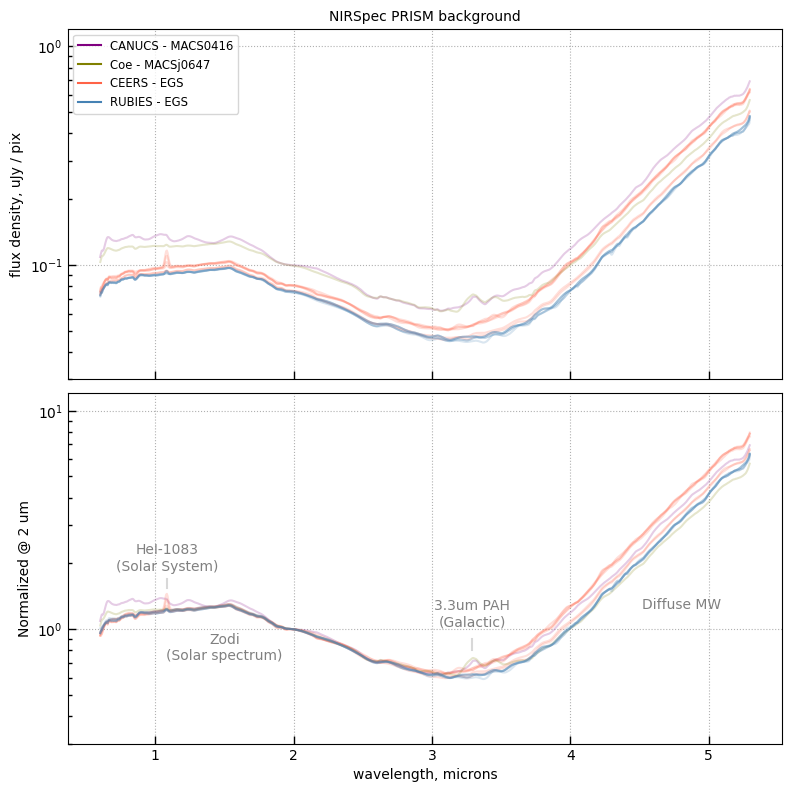

In [83]:
fig, axes = plt.subplots(2,1,figsize=(8,8), sharex=True)

spec_data = []

for file in files:
    b = utils.read_catalog(file)
    
    if file.startswith('jw01345'):
        color = 'tomato'
    elif file.startswith('jw01208'):
        color = 'purple'
    elif file.startswith('jw01433'):
        color = 'olive'
    else:
        color = 'steelblue'

    for i, ax in enumerate(axes):
        ax.plot(b['wave'], b['flux'] / np.interp(2., b['wave'], b['flux'])**i, alpha=0.2, color=color)
    
for ax in axes:
    ax.grid()
    ax.semilogy()

ax.set_xlabel('wavelength, microns')

axes[0].set_ylim(0.03, 1.2)
axes[1].set_ylim(0.3, 12)

ax = axes[0]

ax.plot(b['wave'], b['wave']*0+0.01, color='purple', label='CANUCS - MACS0416')
ax.plot(b['wave'], b['wave']*0+0.01, color='olive', label='Coe - MACSj0647')
ax.plot(b['wave'], b['wave']*0+0.01, color='tomato', label='CEERS - EGS')
ax.plot(b['wave'], b['wave']*0+0.01, color='steelblue', label='RUBIES - EGS')
ax.legend(loc='upper left')

axes[0].set_ylabel('flux density, uJy / pix')
axes[1].set_ylabel('Normalized @ 2 um')

axes[1].text(1.5, 0.7, 'Zodi\n(Solar spectrum)', ha='center', va='bottom', color='0.5')
axes[1].text(4.8, 1.2, 'Diffuse MW', ha='center', va='bottom', color='0.5')
axes[1].text(1.083, 1.8, 'HeI-1083\n(Solar System)', ha='center', va='bottom', color='0.5')
axes[1].plot([1.083, 1.083], [1.55, 1.7], color='0.5', alpha=0.3)

axes[1].text(3.29, 1.0, '3.3um PAH\n(Galactic)', ha='center', va='bottom', color='0.5')
axes[1].plot([3.29, 3.29], [0.8, 0.9], color='0.5', alpha=0.3)

axes[0].set_title('NIRSpec PRISM background')
fig.tight_layout(pad=1)

fig.savefig('nirspec_prism_background.png')